# Importing Full Dataset & Labels

In [ ]:
# !ls
# … you should see: abcd.zip  battery1.jpg  'Best ones Here.zip'

!unzip BEST.zip

Archive:  BEST.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of BEST.zip or
        BEST.zip.zip, and cannot find BEST.zip.ZIP, period.


In [ ]:
!ls


 abcd.zip   battery1.jpg   sample_data	'Untitled Folder'


In [ ]:
import os
folder = 'Archive/CM+RM(without glass sorting)/'
data_path = os.path.join(folder, 'CM_RM_increased.npy')
label_path = os.path.join(folder, 'CM_RM_increased_labels.npy')
# /content/Archive/CM+RM(without glass sorting)/CM_RM_increased.npy

In [ ]:
import numpy as np
X_data = np.load(data_path)
y_labels = np.load(label_path)

In [ ]:
X_data.shape, y_labels.shape

((63900, 32), (63900,))

# Splitting into Test Train (Standard Scaler and SMOTE already applied)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.2, random_state=42)

#GLCM_RM

In [ ]:
import cv2
import numpy as np
import cupy as cp
import pandas as pd
import os

# Path to the single image
single_image_path = 'battery1.jpg'  # Update this to your image path
label = 'plastic'  # Manually provide the label if needed

def quantize_image(image, levels=8):
    factor = 256 // levels
    return (image // factor).astype(np.uint8)

def compute_glcm_features_for_offset(gray, levels=8, offset=(0,1)):
    gpu_img = cp.asarray(gray)
    rows, cols = gpu_img.shape
    dy, dx = offset

    if dy >= 0:
        row_range = slice(0, rows - dy)
        row_range_offset = slice(dy, rows)
    else:
        row_range = slice(-dy, rows)
        row_range_offset = slice(0, rows + dy)

    if dx >= 0:
        col_range = slice(0, cols - dx)
        col_range_offset = slice(dx, cols)
    else:
        col_range = slice(-dx, cols)
        col_range_offset = slice(0, cols + dx)

    a = gpu_img[row_range, col_range]
    b = gpu_img[row_range_offset, col_range_offset]

    a_flat = a.ravel()
    b_flat = b.ravel()
    indices = a_flat * levels + b_flat

    glcm_counts = cp.bincount(indices, minlength=levels*levels).reshape(levels, levels)

    glcm_prob = glcm_counts.astype(cp.float32)
    total = cp.sum(glcm_prob)
    if total > 0:
        glcm_prob /= total

    i = cp.arange(levels).reshape(-1, 1)
    j = cp.arange(levels).reshape(1, -1)

    contrast = cp.sum((i - j)**2 * glcm_prob)
    energy = cp.sum(glcm_prob**2)
    homogeneity = cp.sum(glcm_prob / (1 + cp.abs(i - j)))

    pi = cp.sum(glcm_prob, axis=1, keepdims=True)
    pj = cp.sum(glcm_prob, axis=0, keepdims=True)
    mu_i = cp.sum(i * pi)
    mu_j = cp.sum(j * pj)
    sigma_i = cp.sqrt(cp.sum(((i - mu_i)**2) * pi))
    sigma_j = cp.sqrt(cp.sum(((j - mu_j)**2) * pj))

    if sigma_i == 0 or sigma_j == 0:
        correlation = cp.array(0.0)
    else:
        correlation = cp.sum(((i - mu_i) * (j - mu_j) * glcm_prob) / (sigma_i * sigma_j))

    return {
        'contrast': float(contrast.get()),
        'energy': float(energy.get()),
        'homogeneity': float(homogeneity.get()),
        'correlation': float(correlation.get())
    }

def compute_multidirectional_glcm_features(image, levels=8, offsets=None):
    if offsets is None:
        offsets = {
            '0':   (0, 1),
            '45':  (-1, 1),
            '90':  (-1, 0),
            '135': (-1, -1)
        }

    features = {}
    for direction, off in offsets.items():
        feat = compute_glcm_features_for_offset(image, levels=levels, offset=off)
        for key, value in feat.items():
            features[f"{key}_{direction}"] = value
    return features

# ---------- SINGLE IMAGE PROCESSING ----------
img = cv2.imread(single_image_path, cv2.IMREAD_GRAYSCALE)
if img is not None:
    img_q = quantize_image(img, levels=8)
    feats = compute_multidirectional_glcm_features(img_q, levels=8)
    feats['filename'] = single_image_path
    feats['label'] = label  # You can manually assign or set as 'unknown'
    df_features = pd.DataFrame([feats])  # Wrap in list for DataFrame
    print(df_features.head())
else:
    print("Failed to load image.")


   contrast_0  energy_0  homogeneity_0  correlation_0  contrast_45  energy_45  \
0    0.296675  0.131675       0.912676       0.946557     0.976172   0.102638   

   homogeneity_45  correlation_45  contrast_90  energy_90  homogeneity_90  \
0        0.830353        0.824012     0.854928   0.108887        0.848886   

   correlation_90  contrast_135  energy_135  homogeneity_135  correlation_135  \
0        0.845873      1.010532    0.102897         0.830097         0.817824   

       filename    label  
0  battery1.jpg  plastic  


In [ ]:
feats_list = [i for i in feats.values()]
feats_list

[0.2966746333440824,
 0.13167545199394226,
 0.9126764333603204,
 0.9465571725092083,
 0.976171886704833,
 0.10263821482658386,
 0.8303534002562628,
 0.8240118623220063,
 0.8549281712257653,
 0.1088869571685791,
 0.8488861102247894,
 0.8458726898713468,
 1.0105324271135032,
 0.10289705544710159,
 0.8300967068809683,
 0.8178240960081529,
 'battery1.jpg',
 'plastic']

In [ ]:
feats_list.pop()
feats_list.pop()

'battery1.jpg'

In [ ]:
feats_list

[0.2966746333440824,
 0.13167545199394226,
 0.9126764333603204,
 0.9465571725092083,
 0.976171886704833,
 0.10263821482658386,
 0.8303534002562628,
 0.8240118623220063,
 0.8549281712257653,
 0.1088869571685791,
 0.8488861102247894,
 0.8458726898713468,
 1.0105324271135032,
 0.10289705544710159,
 0.8300967068809683,
 0.8178240960081529]

In [ ]:

# feats_cm = np.array([float(i) for i in feats_list])
# feats_cm

In [ ]:
# def process_image(image_path, label=None, levels=8):
#     # 1) Load the image in grayscale
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     if img is None:
#         raise FileNotFoundError(f"Could not read image at {image_path}")

#     # 2) Quantize
#     img_q = quantize_image(img, levels=levels)

#     # 3) Compute features
#     feats = compute_multidirectional_glcm_features(img_q, levels=levels)

#     # 4) Add metadata
#     feats['filename'] = image_path
#     feats['label'] = label or 'unknown'

#     return feats

# # -------------------------
# # Then just call it:
# single_path = '/path/to/your/image.jpg'
# features_dict = process_image(single_path, label='plastic')

# # If you want a DataFrame:
# import pandas as pd
# df = pd.DataFrame([features_dict])
# print(df)


In [ ]:
import numpy as np
import cv2
import os
import cupy as cp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ---------------------------
# GPU-accelerated helper functions
# ---------------------------

def quantize_image_gpu(d_img, levels=64):
    """Quantize image (a CuPy array) to specified gray levels on the GPU."""
    max_val = cp.max(d_img)
    quantized = cp.floor_divide(d_img, (max_val + 1) // levels)
    return quantized.astype(cp.uint8)

# CUDA kernel for horizontal (0°) run-length computation
horizontal_kernel_code = r'''
extern "C" __global__
void compute_glrlm_horizontal(const unsigned char* img, int height, int width, int glrlm_width, unsigned int* glrlm) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < height) {
        int offset = row * width;
        unsigned char current = img[offset];
        int run_length = 1;
        for (int j = 1; j < width; j++) {
            unsigned char pixel = img[offset + j];
            if (pixel == current) {
                run_length++;
            } else {
                int capped_run = run_length < glrlm_width ? run_length : glrlm_width - 1;
                atomicAdd(&glrlm[current * glrlm_width + capped_run], 1);
                current = pixel;
                run_length = 1;
            }
        }
        int capped_run = run_length < glrlm_width ? run_length : glrlm_width - 1;
        atomicAdd(&glrlm[current * glrlm_width + capped_run], 1);
    }
}
'''

# CUDA kernel for vertical (90°) run-length computation
vertical_kernel_code = r'''
extern "C" __global__
void compute_glrlm_vertical(const unsigned char* img, int height, int width, int glrlm_width, unsigned int* glrlm) {
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (col < width) {
        unsigned char current = img[col]; // first row at this column
        int run_length = 1;
        for (int i = 1; i < height; i++) {
            unsigned char pixel = img[i * width + col];
            if (pixel == current) {
                run_length++;
            } else {
                int capped_run = run_length < glrlm_width ? run_length : glrlm_width - 1;
                atomicAdd(&glrlm[current * glrlm_width + capped_run], 1);
                current = pixel;
                run_length = 1;
            }
        }
        int capped_run = run_length < glrlm_width ? run_length : glrlm_width - 1;
        atomicAdd(&glrlm[current * glrlm_width + capped_run], 1);
    }
}
'''

# CUDA kernel for 45° (diagonal upward-right) computation
diagonal45_kernel_code = r'''
extern "C" __global__
void compute_glrlm_45(const unsigned char* img, int height, int width, int glrlm_width, unsigned int* glrlm) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = height * width;
    if (idx < total) {
        int i = idx / width;
        int j = idx % width;
        unsigned char current = img[i * width + j];
        int run_length = 1;
        int x = i - 1;
        int y = j + 1;
        while (x >= 0 && y < width) {
            if (img[x * width + y] == current) {
                run_length++;
                x--;
                y++;
            } else {
                break;
            }
        }
        int capped_run = run_length < glrlm_width ? run_length : glrlm_width - 1;
        atomicAdd(&glrlm[current * glrlm_width + capped_run], 1);
    }
}
'''

# CUDA kernel for 135° (diagonal downward-right) computation
diagonal135_kernel_code = r'''
extern "C" __global__
void compute_glrlm_135(const unsigned char* img, int height, int width, int glrlm_width, unsigned int* glrlm) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = height * width;
    if (idx < total) {
        int i = idx / width;
        int j = idx % width;
        unsigned char current = img[i * width + j];
        int run_length = 1;
        int x = i + 1;
        int y = j + 1;
        while (x < height && y < width) {
            if (img[x * width + y] == current) {
                run_length++;
                x++;
                y++;
            } else {
                break;
            }
        }
        int capped_run = run_length < glrlm_width ? run_length : glrlm_width - 1;
        atomicAdd(&glrlm[current * glrlm_width + capped_run], 1);
    }
}
'''

# Compile the kernels
horizontal_kernel = cp.RawKernel(horizontal_kernel_code, 'compute_glrlm_horizontal')
vertical_kernel = cp.RawKernel(vertical_kernel_code, 'compute_glrlm_vertical')
diagonal45_kernel = cp.RawKernel(diagonal45_kernel_code, 'compute_glrlm_45')
diagonal135_kernel = cp.RawKernel(diagonal135_kernel_code, 'compute_glrlm_135')

def compute_glrlm_gpu(d_img, direction):
    """
    Compute the GLRLM on the GPU for the given direction.
    d_img: quantized image (CuPy array, uint8) with shape (height, width)
    direction: one of {0, 45, 90, 135}
    Returns a CuPy array representing the GLRLM.
    """
    height, width = d_img.shape
    levels = int(cp.max(d_img).get()) + 1
    max_run_length = max(height, width)
    d_glrlm = cp.zeros((levels, max_run_length), dtype=cp.uint32)

    if direction == 0:
        threads = 32
        blocks = (height + threads - 1) // threads
        horizontal_kernel((blocks,), (threads,), (d_img, height, width, max_run_length, d_glrlm))
    elif direction == 90:
        threads = 32
        blocks = (width + threads - 1) // threads
        vertical_kernel((blocks,), (threads,), (d_img, height, width, max_run_length, d_glrlm))
    elif direction == 45:
        total = height * width
        threads = 256
        blocks = (total + threads - 1) // threads
        diagonal45_kernel((blocks,), (threads,), (d_img, height, width, max_run_length, d_glrlm))
    elif direction == 135:
        total = height * width
        threads = 256
        blocks = (total + threads - 1) // threads
        diagonal135_kernel((blocks,), (threads,), (d_img, height, width, max_run_length, d_glrlm))
    else:
        raise ValueError("Direction must be one of {0, 45, 90, 135}")

    cp.cuda.Stream.null.synchronize()
    return d_glrlm

def extract_glrlm_features_gpu(d_glrlm):
    """Extract GLRLM features on the GPU and return them as a list of floats."""
    total_runs = cp.sum(d_glrlm)
    run_indices = cp.arange(1, d_glrlm.shape[1] + 1, dtype=cp.float32)
    sre = cp.sum(d_glrlm / (run_indices**2)[None, :]) / total_runs
    lre = cp.sum(d_glrlm * (run_indices**2)[None, :]) / total_runs
    gln = cp.sum(cp.sum(d_glrlm, axis=1)**2) / (total_runs**2)
    rln = cp.sum(cp.sum(d_glrlm, axis=0)**2) / (total_runs**2)
    return [float(sre.get()), float(lre.get()), float(gln.get()), float(rln.get())]

def extract_features_from_image_gpu(img_path):
    """
    Read a single image from disk, transfer it to the GPU, quantize it, compute the GLRLM
    for each direction, extract features from each, and concatenate all features.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    d_img = cp.asarray(img)
    d_img = quantize_image_gpu(d_img, levels=16)

    all_features = []
    for direction in [0, 45, 90, 135]:
        d_glrlm = compute_glrlm_gpu(d_img, direction)
        features = extract_glrlm_features_gpu(d_glrlm)
        all_features += features
    return all_features


In [ ]:
feats_rm = extract_features_from_image_gpu('battery1.jpg')

In [ ]:
final = np.array(feats_list+feats_rm)

In [ ]:
final.shape

(32,)

# Creating Ranges for Each Classification

In [ ]:
I_full=[i for i in range(32) ]

In [ ]:
I_10_F_not=[3,7,11,15,18,19,27]
I_10_Ran_For=[8,12,4,10,11,0,7,13,1,3,9,5,15,2,6,14]
I_12_F_not=[16,17,18,19,25,26,27]
I_12_Ran_For=[8,12,4,11,10,3,15,7,0,1,9,5,13,2,6,14]

In [ ]:
I_10_F=I_full[:]
I_12_F=I_full[:]
for i in I_10_F_not:
    I_10_F.remove(i)

for i in I_12_F_not:
    I_12_F.remove(i)


In [ ]:
I_groups = [I_full[:] , I_10_F[:] , I_10_Ran_For[:] , I_full[:] , I_12_F[:] , I_12_Ran_For[:]]

# Ranges Created by above, Now Applying them to the file to be tested

In [ ]:
X_test_cpy=final[:]

In [ ]:
final

array([2.96674633e-01, 1.31675452e-01, 9.12676433e-01, 9.46557173e-01,
       9.76171887e-01, 1.02638215e-01, 8.30353400e-01, 8.24011862e-01,
       8.54928171e-01, 1.08886957e-01, 8.48886110e-01, 8.45872690e-01,
       1.01053243e+00, 1.02897055e-01, 8.30096707e-01, 8.17824096e-01,
       1.52587891e-05, 6.55360000e+04, 1.00000000e+00, 1.00000000e+00,
       4.88105125e-03, 1.11809941e+04, 1.00000000e+00, 5.20831486e-03,
       1.52587891e-05, 6.55360000e+04, 1.00000000e+00, 1.00000000e+00,
       4.88105125e-03, 1.11809941e+04, 1.00000000e+00, 5.20831486e-03])

In [ ]:
X_test_cpy.shape

(32,)

In [ ]:
X_test_parts=[]
for i in I_groups:
    X_test_parts.append(X_test_cpy[i])
for i in X_test_parts:
    print(i.shape)

(32,)
(25,)
(16,)
(32,)
(25,)
(16,)


In [ ]:
import pickle

with open('X_test_parts.pkl', 'wb') as f:
    pickle.dump(X_test_parts, f)


# X_test_parts created now each model to be applied

In [ ]:
full_10=[]
F_10=[]
Ran_10=[]
full_12=[]
F_12=[]
Ran_12=[]

In [ ]:
import joblib
model_10 = "Archive/Best ones Here/10_classes/"
model_12 = "Archive/Best ones Here/12_classes/"


full_10.append(joblib.load(model_10 + 'rf_total_dataset_86.joblib'))
full_10.append(joblib.load(model_10 + 'knn_total_dataset_84.joblib'))

F_10.append(joblib.load(model_10 + 'rf_f_score_84.joblib'))
F_10.append(joblib.load(model_10 + 'knn_f_score_80.joblib'))

Ran_10.append(joblib.load(model_10 + 'rf_rand_fores_class_77.joblib'))
Ran_10.append(joblib.load(model_10 + 'knn_rand_fores_class_76.joblib'))


full_12.append(joblib.load(model_12 + 'rf_total_dataset_87.joblib'))
full_12.append(joblib.load(model_12 + 'knn_total_dataset_86.joblib'))

F_12.append(joblib.load(model_12 + 'rf_f_score_85.joblib'))
F_12.append(joblib.load(model_12 + 'knn_f_score_84.joblib'))

Ran_12.append(joblib.load(model_12 + 'rf_rand_fores_class_78.joblib'))
Ran_12.append(joblib.load(model_12 + 'knn_rand_fores_class_77.joblib'))


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.6.1. This might lead to b

In [ ]:
full_10

[RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(metric='manhattan', n_neighbors=3,
                                       weights='distance'))])]

In [ ]:
models_arr = [full_10,F_10,Ran_10,full_12,F_12,Ran_12]

In [ ]:
full_10

[RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(metric='manhattan', n_neighbors=3,
                                       weights='distance'))])]

In [ ]:
predictions=[]
for i in range(len(X_test_parts)):
    rf_pred = models_arr[i][0].predict_proba(X_test_parts[i])
    knn_pred = models_arr[i][1].predict_proba(X_test_parts[i])
    predictions.append([rf_pred,knn_pred])
len(predictions)

6

In [ ]:
predictions[5][1].shape

(12780, 12)

# Each Model is Applied and Pred Probabilities stored in predictions

In [ ]:
a=np.array([[1,2],[3,4],[5,6]])
b=np.array([[2,3],[4,5],[6,7]])
np.mean(a,axis=1)

array([1.5, 3.5, 5.5])

In [ ]:
(a+b)/2

array([[1.5, 2.5],
       [3.5, 4.5],
       [5.5, 6.5]])

In [ ]:
pred=predictions[:]

In [ ]:
sumed=[]
for i in range(6):
    sum=(pred[i][0]+pred[i][1])/2
    sumed.append(sum)

In [ ]:
sumed[0].shape

(12780, 10)

In [ ]:
bum_10 = np.zeros((12780,10))
bum_12 = np.zeros((12780,12))


In [ ]:
for i in range(3):
    bum_10+=sumed[i]
bum_10/=3
for i in range(3):
    bum_12+=sumed[i+3]
bum_12/=3

In [ ]:
np.max(np.array([[1,2],[32,4],[5,6]]),axis=1)

array([ 2, 32,  6])

In [ ]:
bum_10_cpy=bum_10[:]
bum_12_cpy=bum_12[:]

In [ ]:
bum_10_cpy.shape, bum_12_cpy.shape

((12780, 10), (12780, 12))

In [ ]:
labels_10 = np.argmax(bum_10_cpy,axis=1)
labels_12 = np.argmax(bum_12_cpy,axis=1)

In [ ]:
y_test

array([9, 0, 7, ..., 1, 8, 9])

In [ ]:
labels_12

array([1, 0, 7, ..., 1, 8, 9])

In [ ]:
split_1=(bum_10_cpy[:,[0,1]] + bum_12_cpy[:,[0,1]])/2

In [ ]:
split_2=bum_12_cpy[:,[2]]

In [ ]:
split_3 = (bum_10_cpy[:,[2,3]] + bum_12_cpy[:,[3,4]])/2

In [ ]:
split_4 = bum_12_cpy[:,[5]]

In [ ]:
split_5 = (bum_10_cpy[:,[4,5,6,7,8,9]] + bum_12_cpy[:,[6,7,8,9,10,11]])/2

In [ ]:
final = np.concatenate((split_1,split_2,split_3,split_4,split_5),axis=1)

In [ ]:
final.shape

(12780, 12)

In [ ]:
final_labels = np.argmax(final,axis=1)
final_labels

array([9, 0, 7, ..., 1, 8, 9])

In [ ]:
# 0 , 1 ,     2 , 3       4 , 5 , 6 , 7 , 8 , 9
# 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11

In [ ]:
np.concatenate((np.array([[1,2],[3,4]]),np.array([[5,6,9],[3,4,0]])),axis=1)

array([[1, 2, 5, 6, 9],
       [3, 4, 3, 4, 0]])

In [ ]:
j=0
for i in range(len(final_labels)):
    if final_labels[i]==y_test[i]:
        j+=1

print(j/len(labels_12))

0.8971830985915493


In [ ]:
new_test=[]
for i in y_test:
    if((i==2)|(i==5)|(i==11)):
        new_test.append(9)
    elif (i==3):
        new_test.append(2)
    elif (i==4):
        new_test.append(3)
    elif (i==6):
        new_test.append(4)
    elif (i==7):
        new_test.append(5)
    elif (i==8):
        new_test.append(6)
    elif (i==9):
        new_test.append(7)
    elif (i==10):
        new_test.append(8)
    else:
        new_test.append(i)

np.max(new_test)

np.int64(9)

In [ ]:
j=0
for i in range(len(labels_10)):
    if labels_10[i]==new_test[i]:
        j+=1
    else:
        print(f'At index = {i} ; predicted : {labels_10[i]} ; actual : {new_test[i]}')
# print(j/len(labels_10))

At index = 5 ; predicted : 7 ; actual : 2
At index = 7 ; predicted : 0 ; actual : 9
At index = 17 ; predicted : 7 ; actual : 9
At index = 25 ; predicted : 8 ; actual : 9
At index = 27 ; predicted : 3 ; actual : 4
At index = 31 ; predicted : 3 ; actual : 8
At index = 33 ; predicted : 8 ; actual : 3
At index = 38 ; predicted : 3 ; actual : 9
At index = 48 ; predicted : 8 ; actual : 9
At index = 49 ; predicted : 6 ; actual : 7
At index = 53 ; predicted : 5 ; actual : 3
At index = 54 ; predicted : 1 ; actual : 0
At index = 59 ; predicted : 3 ; actual : 6
At index = 63 ; predicted : 4 ; actual : 9
At index = 65 ; predicted : 4 ; actual : 9
At index = 70 ; predicted : 7 ; actual : 4
At index = 82 ; predicted : 5 ; actual : 1
At index = 87 ; predicted : 6 ; actual : 4
At index = 88 ; predicted : 6 ; actual : 0
At index = 89 ; predicted : 6 ; actual : 4
At index = 91 ; predicted : 5 ; actual : 0
At index = 98 ; predicted : 1 ; actual : 5
At index = 99 ; predicted : 7 ; actual : 0
At index = 10

In [ ]:
len(new_test)

12780

In [ ]:
# 0,1,(2->9),(3->2),(4->3),(5->9),(6->4),(7->5),(8->6),(9->7),(10->8),(11->9)

In [ ]:
pred_max_10 = np.max(bum_10_cpy,axis=1)
pred_max_12 = np.max(bum_12_cpy,axis=1)

In [ ]:
pred_max_12.shape

(12780,)

In [ ]:
np.argmax(np.array([2,9,6,3,4,5,1,0]))

np.int64(1)

In [ ]:
(2,5,11)

(2, 5, 11)

In [ ]:

# ✅ Model Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Prediction
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test set accuracy for this model is : {test_accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred, target_names=cat_12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=cat_12_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_12)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


NameError: name 'model' is not defined

In [ ]:
# ✅ Model Evaluation
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final' from previous cells holds the predicted probabilities
# and you want to get predicted labels
y_pred = np.argmax(final, axis=1)  # Get predicted labels from probabilities

test_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test set accuracy for this model is : {test_accuracy:.2f}")

# Classification report
# Assuming 'cat_12' and 'cat_12_num' are defined in previous cells
# If not, replace them with the appropriate variables or lists
#print(classification_report(y_test, y_pred, target_names=cat_12)) # Commented out as cat_12 and cat_12_num are not defined

# Confusion Matrix
#cm = confusion_matrix(y_test, y_pred, labels=cat_12_num) # Commented out as cat_12_num is not defined
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_12) # Commented out as cat_12 and cat_12_num are not defined
#disp.plot(xticks_rotation=45, cmap='Blues') # Commented out as cat_12 and cat_12_num are not defined
#plt.title("Confusion Matrix") # Commented out as cat_12 and cat_12_num are not defined
#plt.show() # Commented out as cat_12 and cat_12_num are not defined

✅ Test set accuracy for this model is : 0.90


✅ Test set accuracy for this model is : 0.90
              precision    recall  f1-score   support

     class_0       0.96      0.95      0.95      1067
     class_1       0.82      0.96      0.88      1039
     class_2       0.90      0.93      0.91      1042
     class_3       0.87      0.92      0.90      1092
     class_4       0.88      0.74      0.81      1040
     class_5       0.91      0.88      0.90      1049
     class_6       0.91      0.92      0.91      1107
     class_7       0.88      0.92      0.90      1054
     class_8       0.87      0.90      0.89      1054
     class_9       0.91      0.82      0.87      1071
    class_10       0.92      0.96      0.94      1144
    class_11       0.95      0.86      0.90      1021

    accuracy                           0.90     12780
   macro avg       0.90      0.90      0.90     12780
weighted avg       0.90      0.90      0.90     12780



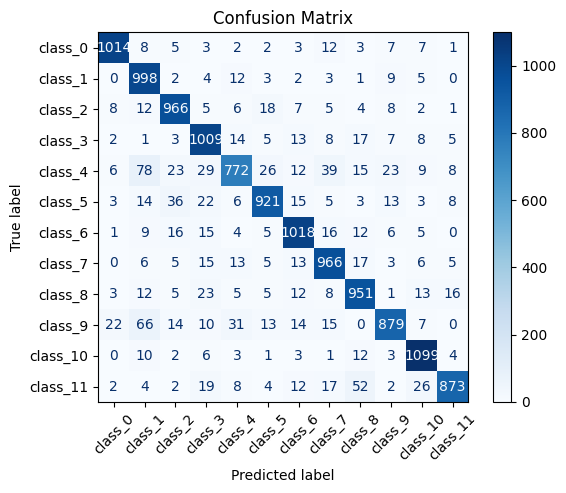

In [ ]:
# ✅ Model Evaluation
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final' from previous cells holds the predicted probabilities
# and you want to get predicted labels
y_pred = np.argmax(final, axis=1)  # Get predicted labels from probabilities

test_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test set accuracy for this model is : {test_accuracy:.2f}")

# Classification report
# Assuming 'cat_12' and 'cat_12_num' are defined in previous cells
# If not, replace them with the appropriate variables or lists
# Define cat_12 and cat_12_num (replace with your actual class names and labels)
cat_12 = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5',
          'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11']
cat_12_num = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

print(classification_report(y_test, y_pred, target_names=cat_12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=cat_12_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_12)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# ✅ Model Evaluation
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final' from previous cells holds the predicted probabilities
# and you want to get predicted labels
y_pred = np.argmax(final, axis=1)  # Get predicted labels from probabilities

test_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test set accuracy for this model is : {test_accuracy:.2f}")

# Classification report
# Assuming 'cat_12' and 'cat_12_num' are defined in previous cells
# If not, replace them with the appropriate variables or lists
print(classification_report(y_test, y_pred, target_names=cat_12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=cat_12_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_12)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

✅ Test set accuracy for this model is : 0.90


ValueError: Number of classes, 12, does not match size of target_names, 12780. Try specifying the labels parameter

In [1]:

# ✅ Feature Correlation Matrix
if isinstance(X_test, pd.DataFrame):
    plt.figure(figsize=(12, 8))
    sns.heatmap(X_test.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Feature Correlation Matrix")
    plt.show()
else:
    print("❗X_test is not a DataFrame. Cannot compute feature correlation matrix.")
